Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.




(784, 2)


C:\Users\PS\AppData\Local\Temp\ipykernel_31240\781516624.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


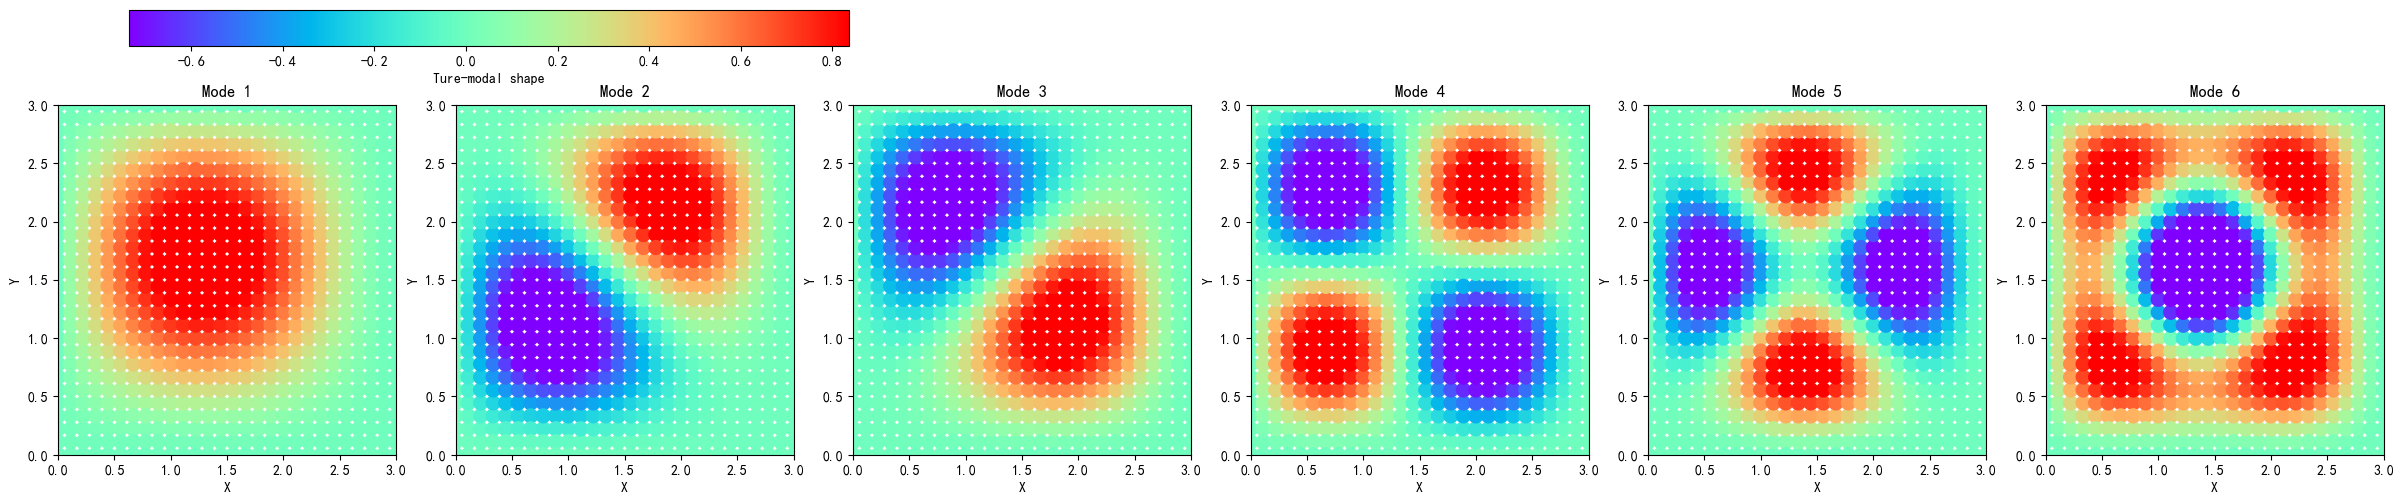

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          384         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 tf_op_layer_strided_slice_1 (T  [(None, 1)]         0           ['input_1[0][0]']                
 ensorFlowOpLayer)                                                                            

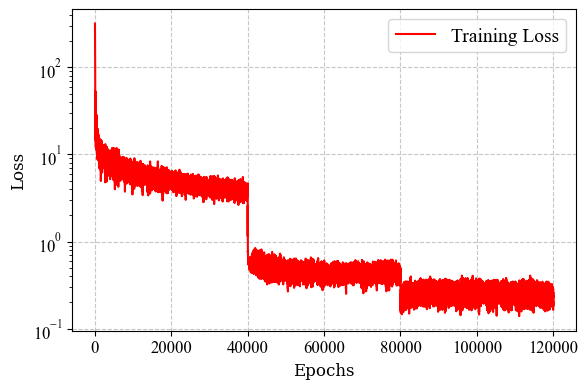

C:\Users\PS\anaconda3\envs\deepxde\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\PS\AppData\Local\Temp\ipykernel_31240\781516624.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


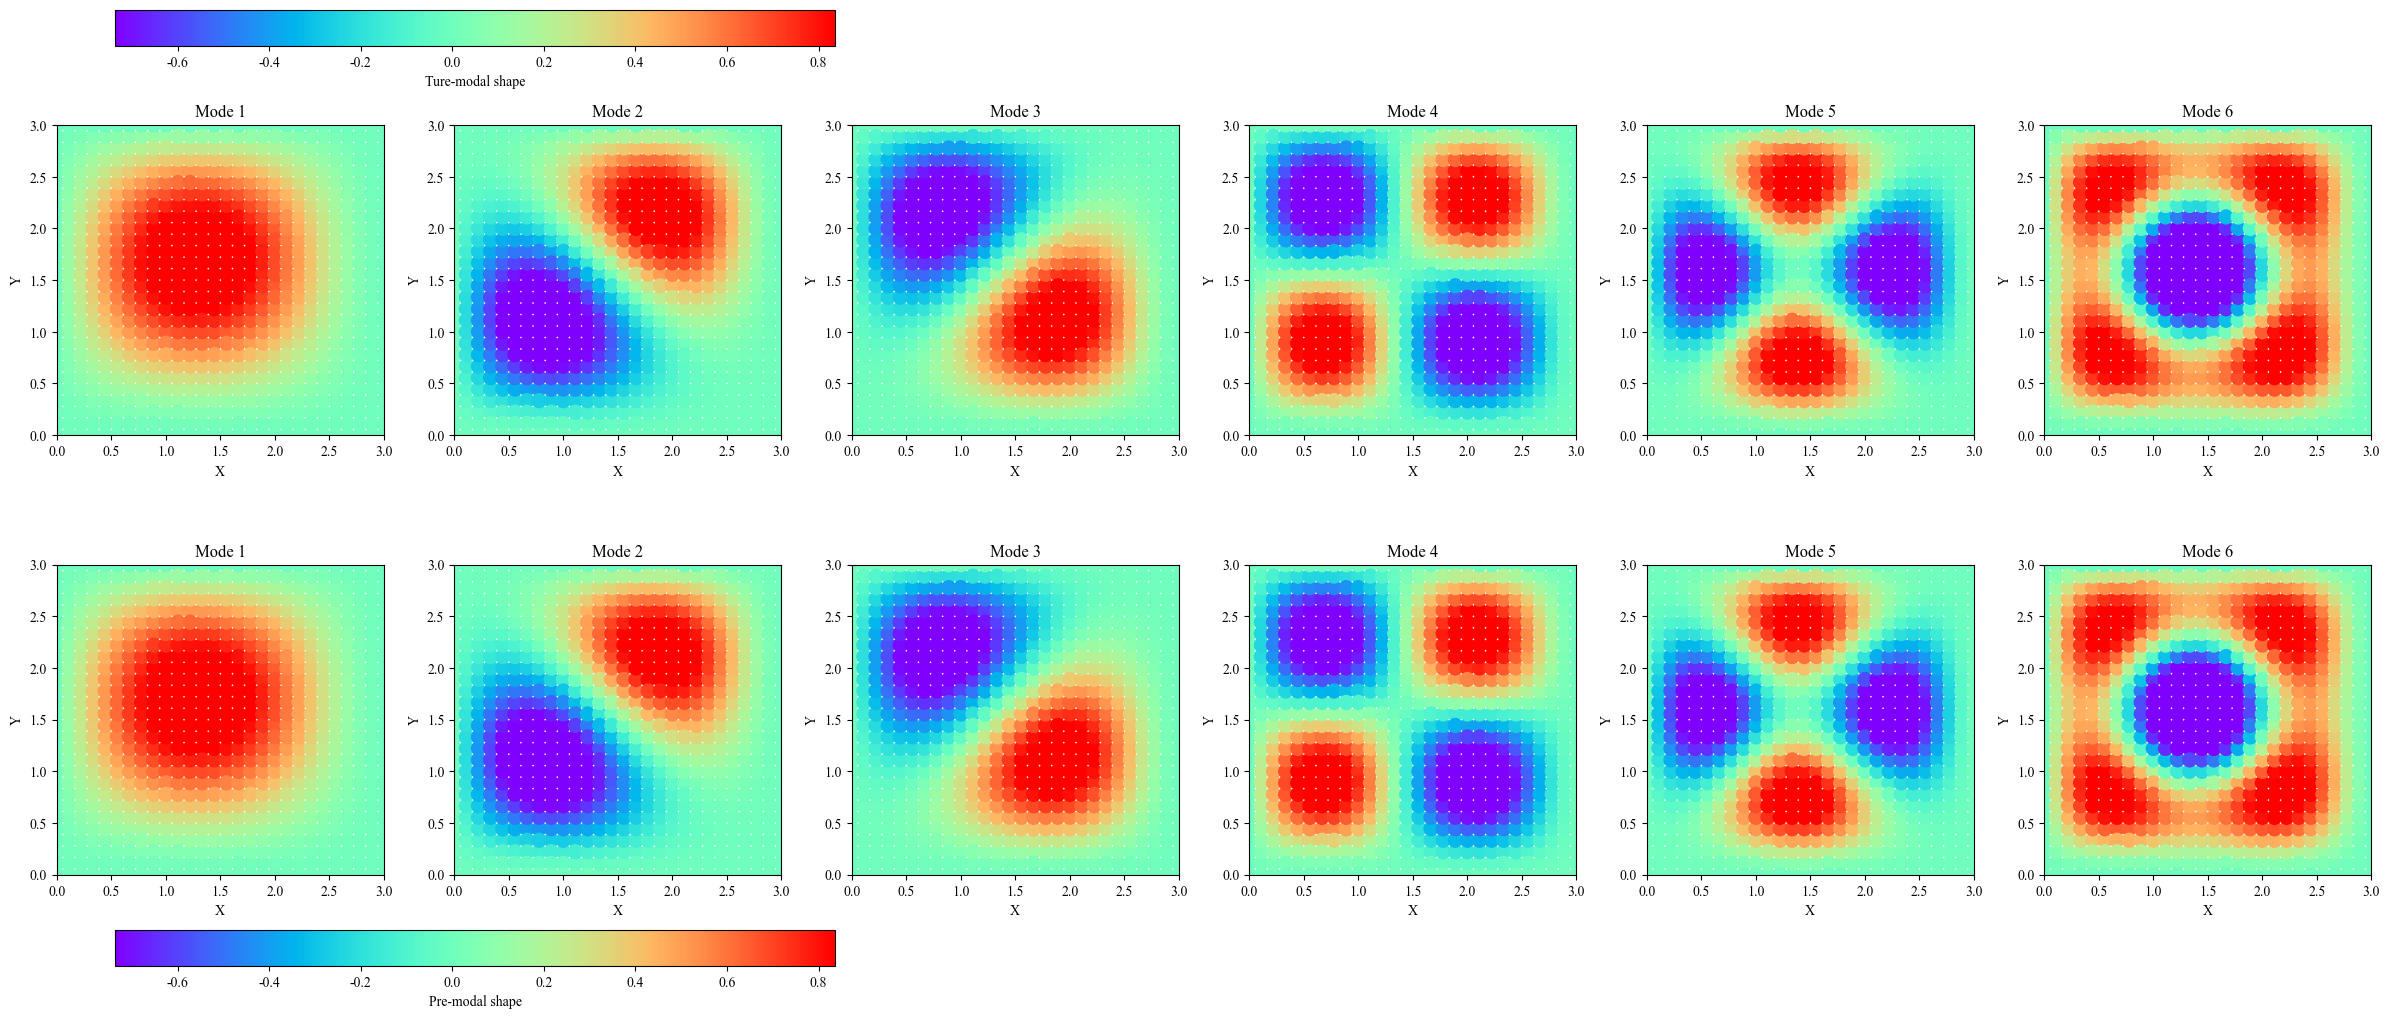

C:\Users\PS\AppData\Local\Temp\ipykernel_31240\781516624.py:254: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from sympy import integrate, exp, sin, log, oo, pi,symbols
import deepxde as dde
import scipy.io as scio
from mpl_toolkits.mplot3d import Axes3D
from deepxde.backend import tf
import datetime
import os
from pylab import mpl
from scipy.signal import chirp, spectrogram
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
from matplotlib.pyplot import MultipleLocator
import re
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from math import sqrt, pi
from matplotlib import colors  # For normalization
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Lambda
from tensorflow.keras.callbacks import LambdaCallback


# 自定义正弦激活函数
def sin_activation(x):
    return tf.math.sin(x)

# 注册自定义激活函数
get_custom_objects().update({'sin': Activation(sin_activation)})

# 加载数据
# 假设文件路径为 'data.txt'

data_pre = np.loadtxt("ban_modal_CL-70.txt")   # 假设文件名为 data.txt


X_pre = data_pre[:, 0].reshape(-1, 1)

Y_pre = data_pre[:, 1].reshape(-1, 1)           # 后 10 列为输出标签

W_pre_1 = data_pre[:, 2:8]

W_pre = W_pre_1 /np.max(W_pre_1 , axis=0)

XY_pre=np.hstack((X_pre, Y_pre))
print(XY_pre.shape)

font = {'family': 'Times New Roman', 'color': 'black', 'weight': 'normal', 'size': 12}


##_____________________________
fig, axes = plt.subplots(1, 6, figsize=(24, 4))
num_modes = 6
# Normalze color range for the plot (with a wider range to increase contrast)
# Adjust vmin and vmax to focus on a tighter range
vmin = np.percentile(W_pre, 5)  # 5th percentile for min value (adjustable)
vmax = np.percentile(W_pre, 95)  # 95th percentile for max value (adjustable)

norm = colors.Normalize(vmin=vmin, vmax=vmax)  # Apply normalization
# Loop through the first 10 modes and plot each one
for i in range(num_modes):
    ax = axes[i]  # Select subplot axis
    mode_data = W_pre[:, i]  # Displacement data for the ith mode
    # Scatter plot for the ith mode shape with increased contrast
    scatter = ax.scatter(X_pre, Y_pre, c=mode_data, cmap='rainbow', norm=norm, s=100)
    ax.set_title(f'Mode {i+1}')  # Set the title for each subplot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim([0,3])
    ax.set_xlim([0,3])
# Add colorbar for the plots
cbar = fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.2, pad=0.5, label='Ture-modal shape')
# Adjust the position of the colorbar (move it outside the plot area)
cbar.ax.set_position([0.05, 0.25, 0.3, 0.9])  # Adjust this to make it larger and in a good position

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
#_________________________________模型m


# 定义网络的超参数
w_nodenum_pre =128 # 每一层的神经元数
w_layer_pre = 5   # 隐藏层的数量
activation_func_pre = "relu"  # 隐藏层使用的激活函数

# 定义 modify_output 函数：应用于模型的输出

# def modify_output_pre(X):
#     ww = []
#     for i in range(5):  # Create 5 sub-networks
#         ww_subnetwork = tf.keras.layers.Dense(w_nodenum_pre, activation=activation_func_pre)(X)
#         for _ in range(w_layer_pre):  # Each sub-network has multiple layers
#             ww_subnetwork = tf.keras.layers.Dense(w_nodenum_pre, activation=activation_func_pre)(ww_subnetwork)
#         ww_subnetwork = X[:, 0:1] * X[:, 1:2] * (X[:, 1:2] - 3) * (X[:, 0:1] - 3) * tf.keras.layers.Dense(1, activation=None)(ww_subnetwork)  # Last layer scaling
#         ww.append(ww_subnetwork)  # Add the output of each sub-network to the list
#     ww = tf.concat(ww, axis=1)  # Concatenate all sub-network outputs along axis 1
#     return ww

def modify_output_pre(X):
    ww = tf.keras.layers.Dense(w_nodenum_pre, activation=activation_func_pre)(X)
    for i in range(w_layer_pre):  
        ww = tf.keras.layers.Dense(w_nodenum_pre, activation=activation_func_pre)(ww)
    ww = X[:, 0:1]* (X[:, 0:1] - 3) * X[:, 1:2] * (X[:, 1:2] - 3)  * tf.keras.layers.Dense(6, activation=None)(ww)
    return ww



# 创建模型的输入层，假设输入维度是 2
inputs_pre = tf.keras.Input(shape=(2,))
output_pre = modify_output_pre(inputs_pre)

# 创建模型
pre_model = tf.keras.Model(inputs=inputs_pre, outputs=output_pre)

# 查看模型概况
pre_model.summary()
# 假设你有训练数据：X_train 和 Y_train
# 例如，X_train 是输入数据，Y_train 是目标数据
# model.compile(optimizer='adam', loss='mse')
# model.fit(X_train, Y_train, epochs=100, batch_size=32)

# Define the learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 40000:
        return 0.001  # First 40000 epochs
    elif epoch >=40000 and epoch < 80000:
        return 0.0001  # Next 5000 epochs
    else:
        return 0.00005   # Return current lr after epoch 45000, or change it as needed

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

tf.compat.v1.disable_eager_execution()

# 4. 创建并编译模型来拟合sin(x)
def weighted_mae(y_true, y_pred):
    # 假设我们有一个权重向量
    weights = tf.constant(1000.00000)  # 设置不同的权重
    return tf.reduce_mean(weights * tf.abs(y_true - y_pred), axis=-1)

history1 = pre_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=weighted_mae,  # 使用 Mean Absolute Error
    metrics=['accuracy']
)

# 自定义回调函数，每 1000 个 epoch 打印一次损失
def on_epoch_end(epoch, logs):
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch + 1}, Loss: {logs['loss']:.4f}")

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
history1 = pre_model.fit(
    XY_pre, W_pre,
    epochs=120000,  # 训练 60000 个 epoch
    batch_size=2048,  # 在此处指定 batch_size
    callbacks=[print_callback, lr_scheduler],  # 包含自定义回调和学习率调度
    verbose=0  # 静默模式
)


plt.figure(figsize=(6, 4))
plt.rcParams['font.family'] = 'Times New Roman'
# 绘制训练损失曲线
plt.plot(history1.history['loss'], label='Training Loss', color='red', linestyle='-')
# 设置对数坐标
plt.yscale('log')
# 设置标题和标签
plt.title('', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
plt.xlabel('Epochs', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
plt.ylabel('Loss', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
# 显示图例
plt.legend(fontsize=14)
# 设置坐标轴刻度标签的字体大小
plt.tick_params(axis='both', which='major', labelsize=12)
# 布局调整
plt.tight_layout()
# 添加网格
plt.grid(True, linestyle='--', alpha=0.7)
# 保存图片
plt.savefig('modal_train.png', dpi=300)
# 显示图表
plt.show()

##-_____冻结层，
for layer in pre_model.layers:
    layer.trainable = False

# 预测训练集
W_train_pred = pre_model.predict(XY_pre)

##——————————————————————————————————————————————对比画图
fig, axes = plt.subplots(2,6, figsize=(24, 8))
num_modes = 6

vmin2 = np.percentile(W_train_pred, 5)  
vmax2 = np.percentile(W_train_pred, 95)  
norm = colors.Normalize(vmin=vmin2, vmax=vmax2)  # Apply normalization
# ————真实值画图-------------------------------------------------
for k in range(num_modes):
    ax = axes[0,k]  
    mode_data = W_pre[:, k] 
    scatter = ax.scatter(X_pre, Y_pre, c=mode_data, cmap='rainbow', norm=norm, s=100)
    ax.set_title(f'Mode {k+1}') 
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim([0,3])
    ax.set_xlim([0,3])
cbar = fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.2, pad=0.5, label='Ture-modal shape')
cbar.ax.set_position([0.05, 0.20, 0.3, 0.9])  
# ————预测值画图-------------------------------------------------
for j in range(num_modes):
    ax = axes[1,j]  
    mode_data_pred = W_train_pred[:, j]  
    scatter = ax.scatter(X_pre, Y_pre, c=mode_data_pred, cmap='rainbow', norm=norm, s=100)
    ax.set_title(f'Mode {j+1}')  
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim([0,3])
    ax.set_xlim([0,3])
cbar = fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.2, pad=0.5, label='Pre-modal shape')
cbar.ax.set_position([0.05, -0.95, 0.3, 0.9])  

plt.tight_layout()
plt.show()
##误差画图——————————————————————————————————————————————

lOSSa=  W_pre[:, 0:6]-W_train_pred[:, 0:6]
fig, axes = plt.subplots(1, 6, figsize=(24,4))
num_modes = 6
vmin3 = np.percentile(lOSSa, 5) 
vmax3 = np.percentile(lOSSa, 95) 
norm = colors.Normalize(vmin=vmin3, vmax=vmax3)  
for k in range(num_modes):
    ax = axes[k] 
    scatter = ax.scatter(X_pre, Y_pre, c=lOSSa[:, k], cmap='rainbow', norm=norm, s=100)
    ax.set_title(f'Mode {k+1}')  
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim([0,3])
    ax.set_xlim([0,3])
cbar = fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.2, pad=0.5, label='Error')
cbar.ax.set_position([0.05, 0.25, 0.3, 0.9])  
plt.tight_layout()
plt.show()


C:\Users\PS\AppData\Local\Temp\ipykernel_31240\1254525665.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


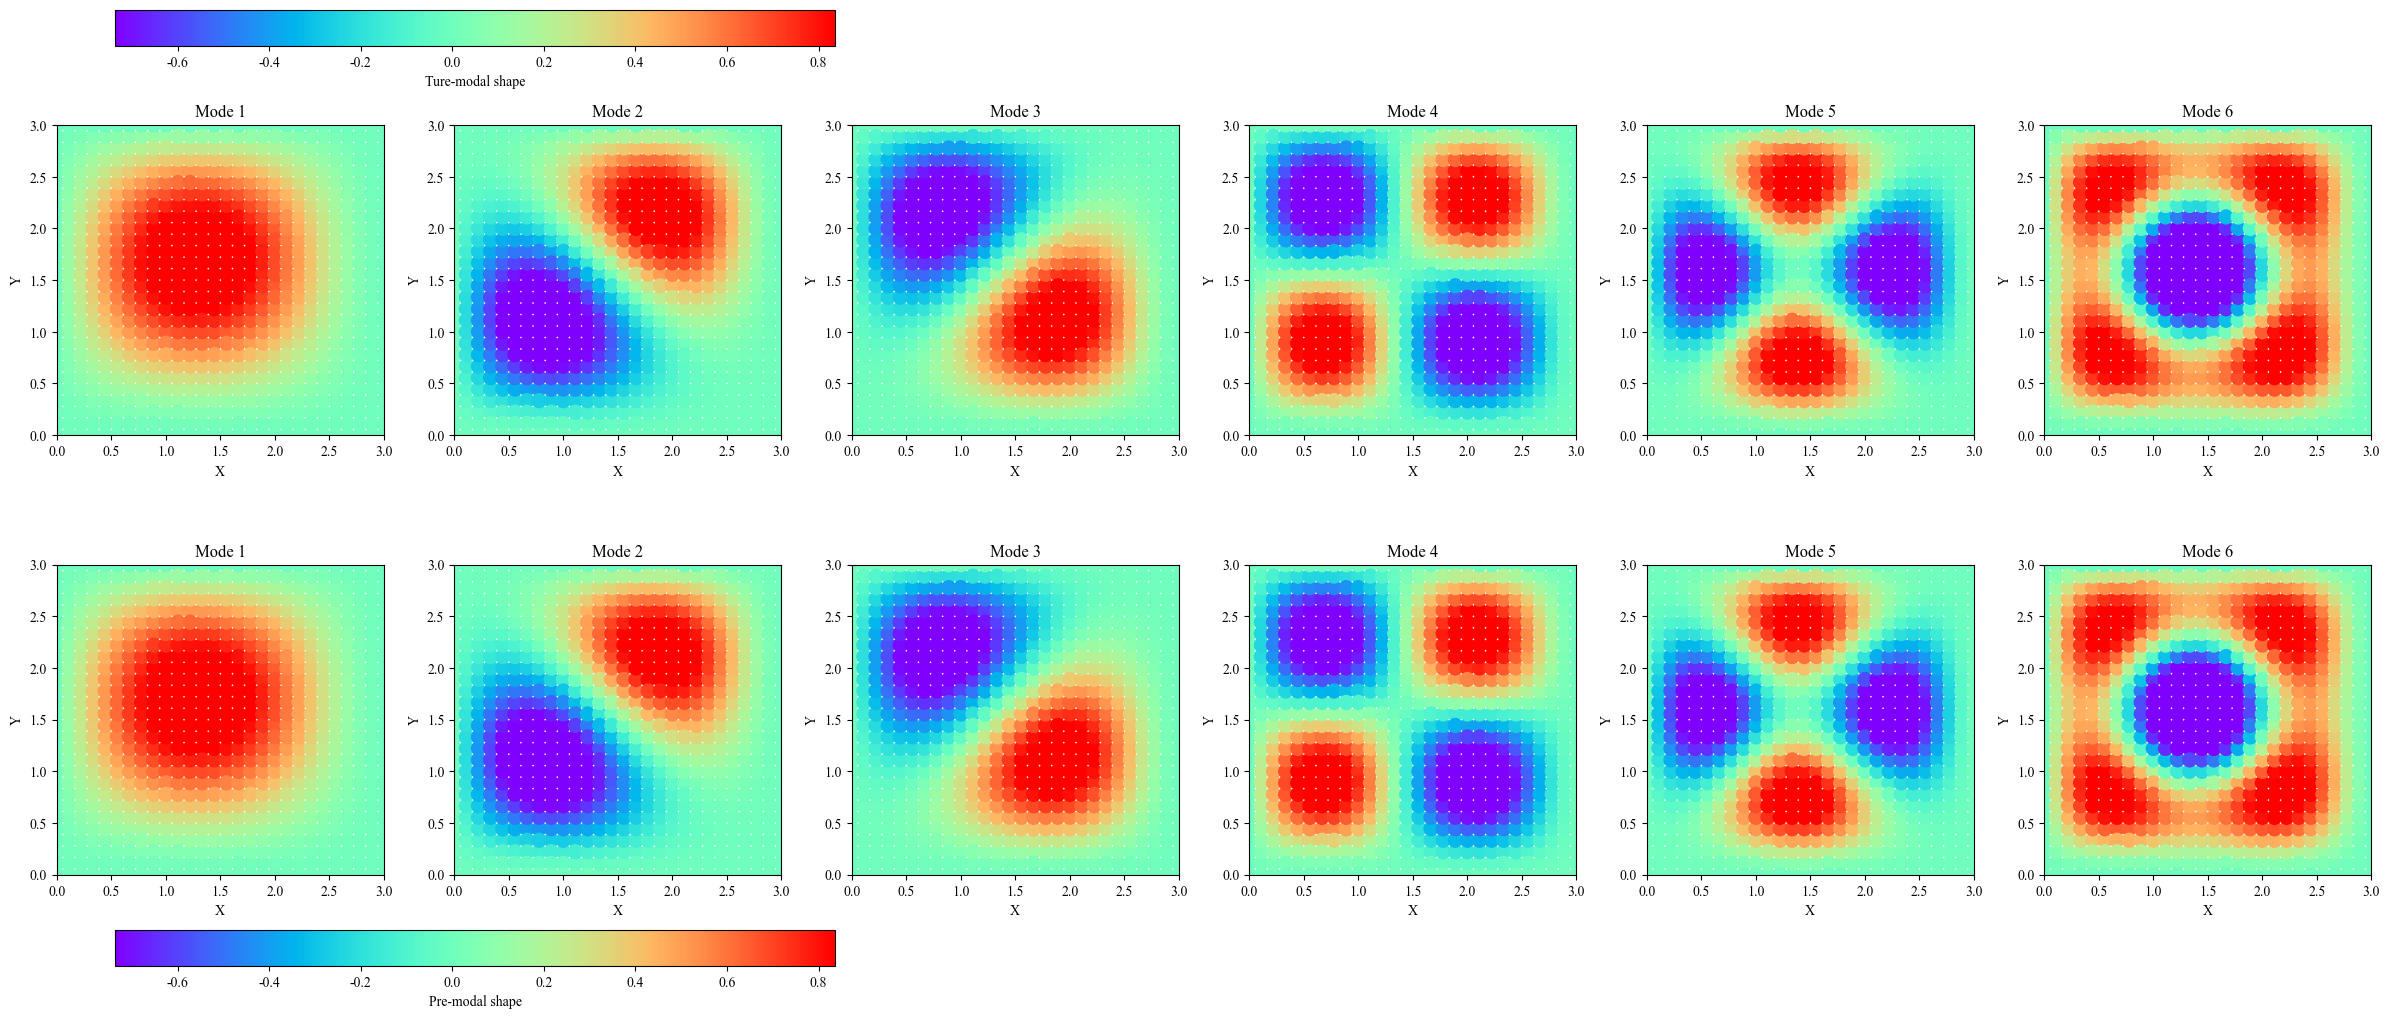

C:\Users\PS\AppData\Local\Temp\ipykernel_31240\1254525665.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [2]:
##——————————————————————————————————————————————对比画图
fig, axes = plt.subplots(2,6, figsize=(24, 8))
num_modes = 6

vmin2 = np.percentile(W_train_pred, 5)  
vmax2 = np.percentile(W_train_pred, 95)  
norm = colors.Normalize(vmin=vmin2, vmax=vmax2)  # Apply normalization
# ————真实值画图-------------------------------------------------
for k in range(num_modes):
    ax = axes[0,k]  
    mode_data = W_pre[:, k] 
    scatter = ax.scatter(X_pre, Y_pre, c=mode_data, cmap='rainbow', norm=norm, s=100)
    ax.set_title(f'Mode {k+1}') 
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim([0,3])
    ax.set_xlim([0,3])
cbar = fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.2, pad=0.5, label='Ture-modal shape')
cbar.ax.set_position([0.05, 0.20, 0.3, 0.9])  
# ————预测值画图-------------------------------------------------
for j in range(num_modes):
    ax = axes[1,j]  
    mode_data_pred = W_train_pred[:, j]  
    scatter = ax.scatter(X_pre, Y_pre, c=mode_data_pred, cmap='rainbow', norm=norm, s=100)
    ax.set_title(f'Mode {j+1}')  
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim([0,3])
    ax.set_xlim([0,3])
cbar = fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.2, pad=0.5, label='Pre-modal shape')
cbar.ax.set_position([0.05, -0.95, 0.3, 0.9])  

plt.tight_layout()
plt.show()
##误差画图——————————————————————————————————————————————

lOSSa=  W_pre[:, 0:6]-W_train_pred[:, 0:6]
fig, axes = plt.subplots(1, 6, figsize=(24,4))
num_modes = 6
vmin3 = np.percentile(lOSSa, 5) 
vmax3 = np.percentile(lOSSa, 95) 
norm = colors.Normalize(vmin=vmin3, vmax=vmax3)  
for k in range(num_modes):
    ax = axes[k] 
    scatter = ax.scatter(X_pre, Y_pre, c=lOSSa[:, k], cmap='rainbow', norm=norm, s=100)
    ax.set_title(f'Mode {k+1}')  
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim([0,3])
    ax.set_xlim([0,3])
cbar = fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.2, pad=0.5, label='Error')
cbar.ax.set_position([0.05, 0.25, 0.3, 0.9])  
plt.tight_layout()
plt.show()


In [10]:

#————————————————————— 数据处理 ———————————————————————#
def generate_labeled_data():
    data_w = np.loadtxt("ban_weiyi-CL.txt")
    x_data = data_w[:, 0].reshape(-1, 1)  # 第一列为输入特征，调整形状为二维
    y_data = data_w[:, 1].reshape(-1, 1)  # 第一列为输入特征，调整形状为二维
    w_data = data_w[:, 2:]  # 假设 y_data 从第三列到2003列
    t_data = np.arange(0, 5.01, 0.01).reshape(-1, 1).T# 生成 t 数据，3001x1101*1
    XY_data = np.hstack((x_data, y_data))  # Add an extra dimension for stacking
    valid_indices = (t_data >= 0.1) & (t_data <= 3.1)
    t_data_filtered = t_data[valid_indices]
    w_data_filtered = w_data[:,valid_indices.flatten()]  # 保留所有空间位置的过滤时间步
    coordinates = [(0.72,0.72),(0.72,1.5),(0.72,2.28),(1.5,0.72),(1.5,1.5),(1.5,2.28),(2.28,0.72),(2.28,1.5),(2.28,2.28)]
    selected_w = []
    selected_x = []
    selected_y = []
    for (x, y) in coordinates:
    # 查找符合条件的 x 和 y 坐标
        matches = np.isclose(XY_data[:, 0], x) & np.isclose(XY_data[:, 1], y)
        if np.any(matches):  # If there are any matches
            selected_indices = np.where(matches)[0]
            selected_w.append(w_data_filtered[selected_indices[0]])
            selected_x.append(x_data[selected_indices[0]])
            selected_y.append(y_data[selected_indices[0]])
    selected_w = np.array(selected_w)
    selected_x = np.array(selected_x)
    selected_y = np.array(selected_y)
    T,X = np.meshgrid(t_data_filtered.flatten(), selected_x.flatten())
    T,Y= np.meshgrid(t_data_filtered.flatten(), selected_y.flatten())
    inputs = np.hstack([X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]])
    outputs = selected_w.flatten()[:, None]
    # 输出输入和输出的形状
    return inputs, outputs
#————————————————————— 数据处理 ———————————————————————#

xyt_data, w_data = generate_labeled_data()

#————————————————————— 损失函数定义 ———————————————————————#

observe_y1 = dde.icbc.PointSetBC(xyt_data, w_data, component=0)  #标签数据

geom = dde.geometry.Rectangle([0, 0], [1, 1])
timedomain = dde.geometry.TimeDomain(0, 2) #时间域
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def beam(X, Y):  
    a =0.0*Y
    return a
data = dde.data.TimePDE(geomtime,
                        beam, 
                        observe_y1,  # 使用 PointSetBC
                        num_domain=1,
                        num_boundary=0)#anchors=xt_data
train_points = data.train_x

# 绘制采样点
plt.figure(figsize=(8, 6))
plt.scatter(train_points[:, 0], train_points[:, 1], s=10, alpha=0.6, label="Sample Points")
plt.xlabel("x")
plt.ylabel("y")

plt.xlim([0,3])
plt.ylim([0,3])
plt.title("Sample Points in Space-Time Domain")
plt.legend()
plt.show()

#————————————————————— 网络架构 ———————————————————————#
net = dde.maps.FNN([3] + [7], None, "Glorot uniform")    #基础架构
w_nodenum = 128
w_layer = 4
activation_func = "relu"
def modify_output(X, Y):   #修正架构
    XY = X[:,0:2]
    t = X[:,2:3]
    y1 = tf.zeros_like(t)  # 创建与 x 形状相同的零张量
    w = []
    for i in range(6):  # 创建 6 个子网络
        w_subnetwork = tf.layers.dense(t, w_nodenum, activation_func)
        for _ in range(w_layer):  # 每个子网络中有多层
            w_subnetwork = tf.layers.dense(w_subnetwork, w_nodenum, activation_func)
        w_subnetwork = 0.0001 * tf.layers.dense(w_subnetwork, 1, None)  # 最后一层缩放
        w.append(w_subnetwork)  # 将每个子网络的输出添加到 w 列表中
    w = tf.concat(w, axis=1)  # 将所有子网络的输出合并在一起

    FAI= pre_model(XY)#*X[:,0:1]*X[:,1:2]*(X[:,1:2]-3)
    for i in range(1,7):
        wi_term = w[:, (i - 1):i]
        FAIi_term=FAI[:, (i - 1):i]
        y1 += wi_term * FAIi_term  # 逐项累加 
    return tf.concat([y1, w], axis=1)  
     # r= tf.layers.dense(X, w_nodenum, activation_func)
    # for i in range(w_layer):
    #     r = tf.layers.dense(r, 64, activation_func)
    # r =0*tf.layers.dense(w, 1, None)
   # y2 = y1 #+ r
#tf.concat([y, MM,], axis=1)

net.apply_output_transform(modify_output)
model = dde.Model(data, net)




#————————————————————— 训练定义 ———————————————————————#

epochs=10000
#variable = dde.callbacks.VariableValue(D, period=1000, filename="variables.dat")

model.compile("adam",
              lr=1e-3,loss=["MAE","MAE"],loss_weights=[0,1e7])
# Start training for a few iterations to initialize the weights

# Now you should be able to print the model parameters
loss_history, train_state = model.train(iterations=6*epochs, 
                                        display_every=1000, 
                                        disregard_previous_best=True)

#10,1e7,1e8,1,1,1,1
model.compile("adam",
              lr=1e-4,loss=["MAE","MAE"],loss_weights=[0,1e7])
loss_history, train_state = model.train(iterations=6*epochs, 
                                        display_every=1000, 
                                        disregard_previous_best=True)
#10,1e7,1e8,1,1,1,1
model.compile("adam",
              lr=1e-5,loss=["MAE","MAE"],loss_weights=[0,1e7])
loss_history, train_state = model.train(iterations=6*epochs, 
                                        display_every=1000, 
                                        disregard_previous_best=True)

#————————————————————— 损失函数 ———————————————————————#

# 假设 train_loss 包含每个 epoch 的损失值
train_loss = loss_history.loss_train
# 提取每个 epoch 的第一个损失值（假设是物理损失）和第二个损失值（假设是数据损失）
physics_losses = [loss[0] for loss in train_loss]
data1_losses = [loss[1] for loss in train_loss]


total_losses = [p + d for p, d in zip(physics_losses, data1_losses)]

epochs = np.arange(len(train_loss)) * 1000  # 假设每个点是 1000 个 epoch

font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12}

    # 绘制损失函数
plt.figure(figsize=(6, 4))
# 使用不同的线型和颜色
plt.plot(epochs, data1_losses, label='Data Loss', color='orange', linestyle='-', linewidth=2)  # 虚线
#plt.plot(epochs, physics_losses, label='Physics Loss', color='blue', linestyle='-.')  # 点划线
#plt.plot(epochs, total_losses, label='Total Loss', color='red', linestyle='-')  # 点线
plt.yscale('log')  # 将 Y 轴设置为对数坐标
plt.title('', fontdict=font)
plt.xlabel('Epochs', fontdict=font)
plt.ylabel('Loss', fontdict=font)

plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)  # 更加淡化的网格
plt.savefig("损失函数.png", dpi=300)
plt.show()


Compiling model...
Building feed-forward neural network...


C:\Users\PS\anaconda3\envs\deepxde\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
C:\Users\PS\AppData\Local\Temp\ipykernel_31240\3144519567.py:78: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  w_subnetwork = tf.layers.dense(t, w_nodenum, activation_func)
C:\Users\PS\AppData\Local\Temp\ipykernel_31240\3144519567.py:80: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  w_subnetwork = tf.layers.dense(w_subnetwork, w_nodenum, activation_func)
C:\Users\PS\AppData\Local\Temp\ipykernel_31240\3144519567.py:81: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  w_subnetwork = 0.0001

'build' took 0.227762 s

'compile' took 0.992475 s

Training model...

Step      Train loss              Test loss               Test metric
0         [0.00e+00, 1.57e+04]    [0.00e+00, 1.57e+04]    []  
1000      [0.00e+00, 7.22e+03]    [0.00e+00, 7.22e+03]    []  
2000      [0.00e+00, 3.74e+03]    [0.00e+00, 3.74e+03]    []  
3000      [0.00e+00, 2.46e+03]    [0.00e+00, 2.46e+03]    []  
4000      [0.00e+00, 2.33e+03]    [0.00e+00, 2.33e+03]    []  
5000      [0.00e+00, 2.01e+03]    [0.00e+00, 2.01e+03]    []  
6000      [0.00e+00, 1.69e+03]    [0.00e+00, 1.69e+03]    []  
7000      [0.00e+00, 1.37e+03]    [0.00e+00, 1.37e+03]    []  
8000      [0.00e+00, 1.47e+03]    [0.00e+00, 1.47e+03]    []  
9000      [0.00e+00, 1.26e+03]    [0.00e+00, 1.26e+03]    []  
10000     [0.00e+00, 1.50e+03]    [0.00e+00, 1.50e+03]    []  
11000     [0.00e+00, 1.38e+03]    [0.00e+00, 1.38e+03]    []  
12000     [0.00e+00, 1.68e+03]    [0.00e+00, 1.68e+03]    []  
13000     [0.00e+00, 1.33e+03]    [0.00e

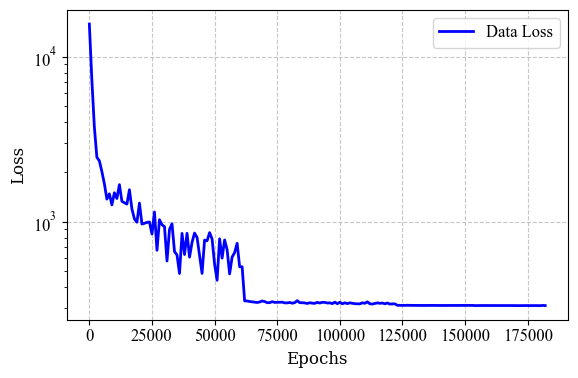

In [11]:
# 假设 train_loss 包含每个 epoch 的损失值
train_loss = loss_history.loss_train
# 提取每个 epoch 的第一个损失值（假设是物理损失）和第二个损失值（假设是数据损失）
physics_losses = [loss[0] for loss in train_loss]
data1_losses = [loss[1] for loss in train_loss]


total_losses = [p + d for p, d in zip(physics_losses, data1_losses)]

epochs = np.arange(len(train_loss)) * 1000  # 假设每个点是 1000 个 epoch

font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12}

    # 绘制损失函数
plt.figure(figsize=(6, 4))
# 使用不同的线型和颜色
plt.plot(epochs, data1_losses, label='Data Loss', color='blue', linestyle='-', linewidth=2)  # 虚线
#plt.plot(epochs, physics_losses, label='Physics Loss', color='blue', linestyle='-.')  # 点划线
#plt.plot(epochs, total_losses, label='Total Loss', color='red', linestyle='-')  # 点线
plt.yscale('log')  # 将 Y 轴设置为对数坐标
plt.title('', fontdict=font)
plt.xlabel('Epochs', fontdict=font)
plt.ylabel('Loss', fontdict=font)

plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)  # 更加淡化的网格
plt.savefig("损失函数.png", dpi=300)
plt.show()

int32


C:\Users\PS\AppData\Local\Temp\ipykernel_31240\3477663717.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


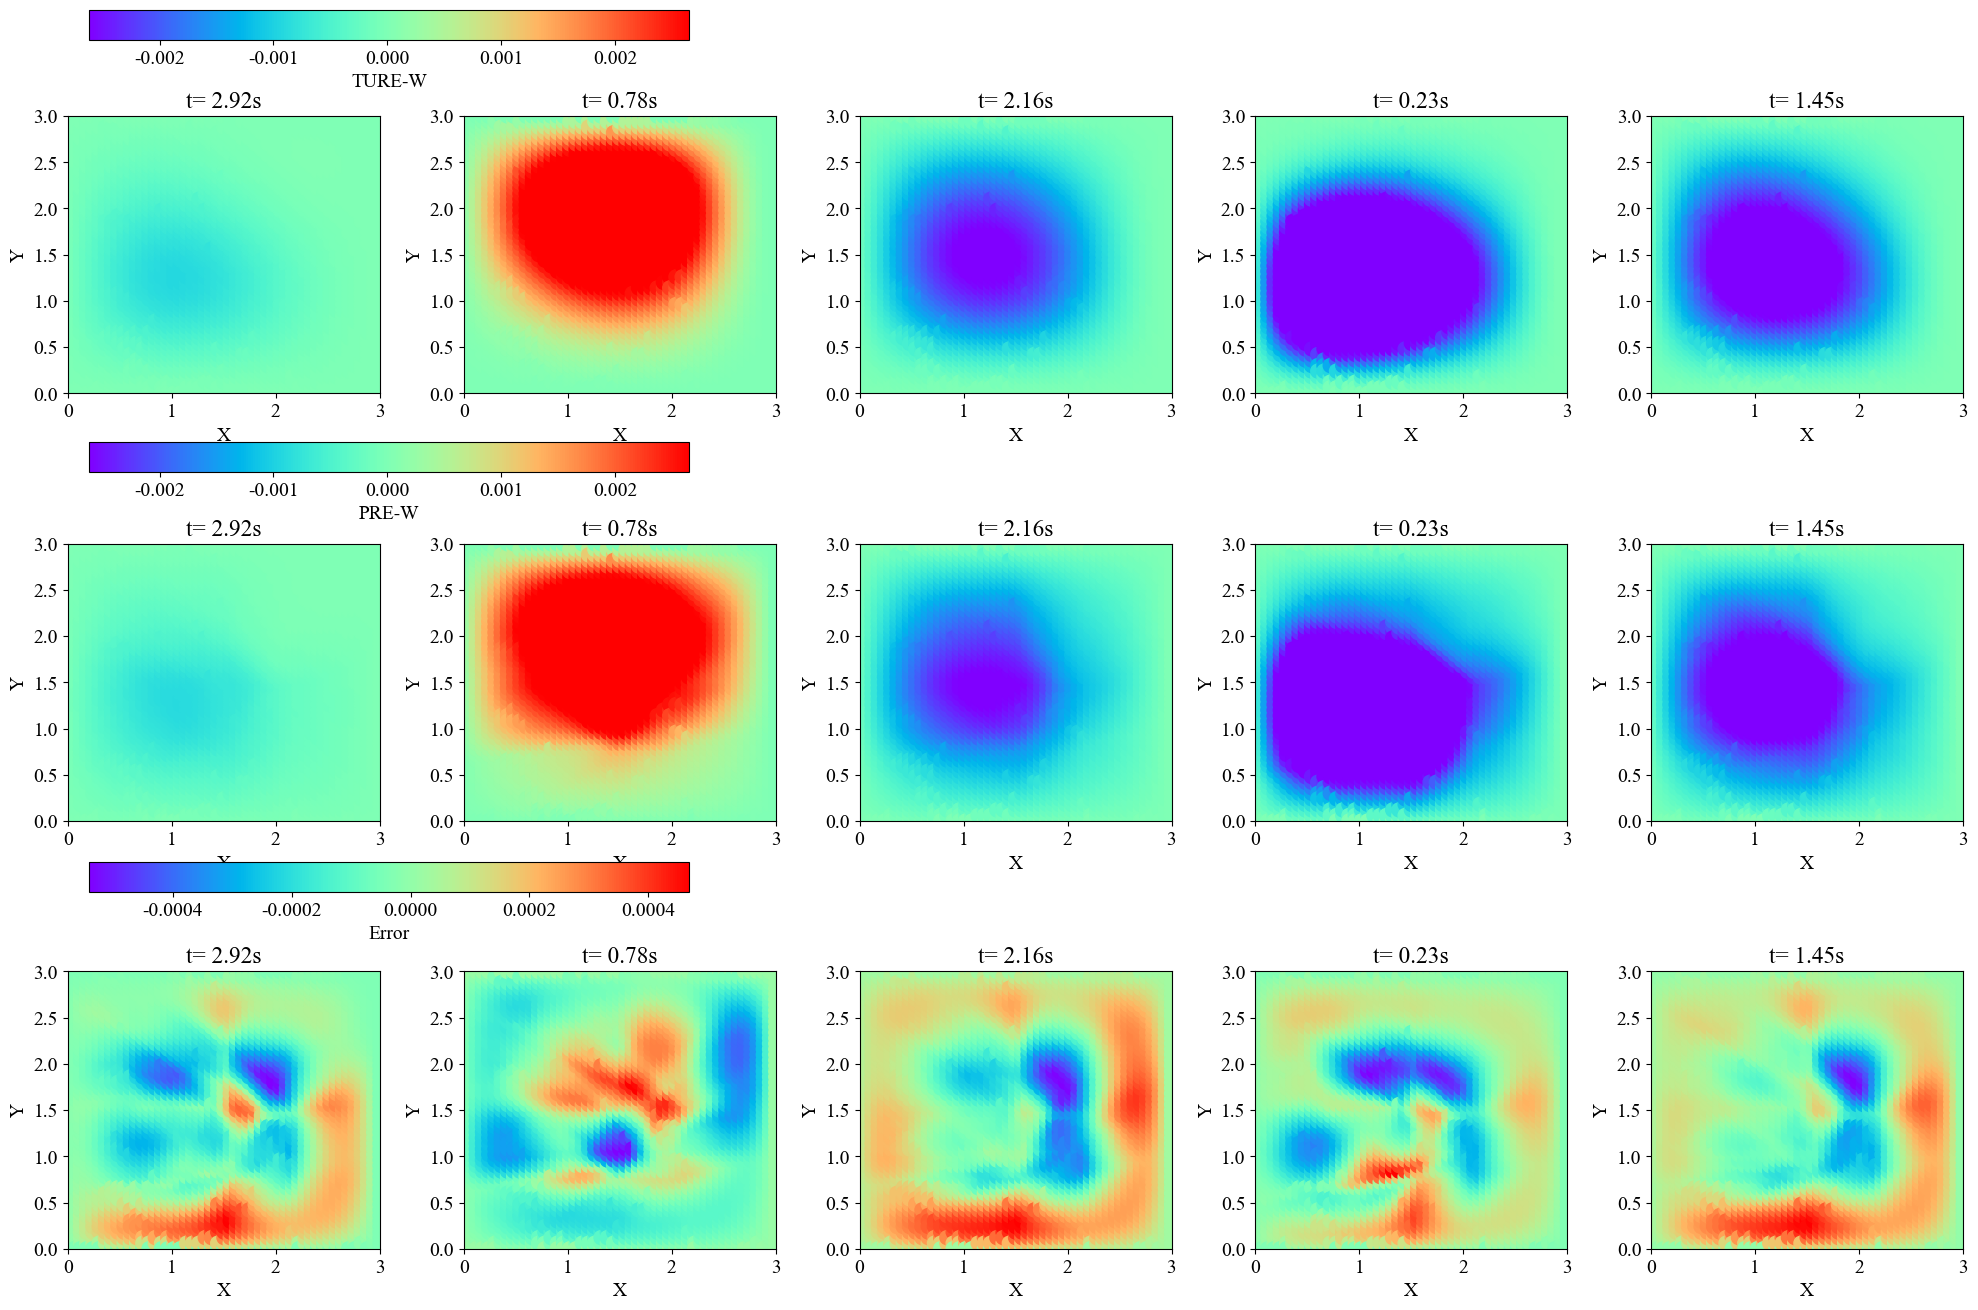

In [12]:
def generate_labeled_data2():
    data_w = np.loadtxt("ban_weiyi-CL.txt")
    x_data = data_w[:, 0].reshape(-1, 1)  # 第一列为输入特征，调整形状为二维
    y_data = data_w[:, 1].reshape(-1, 1)  # 第一列为输入特征，调整形状为二维
    w_data = data_w[:, 2:] # 假设 y_data 从第三列到2003列HHHGGG
    t_data = np.arange(0, 5.01, 0.01).reshape(-1, 1).T# 生成 t 数据，3001x1101*1
    XY_data = np.hstack((x_data, y_data))  # Add an extra dimension for stacking
    valid_indices = (t_data >= 0.1) & (t_data <= 3.1)
    t_data_filtered = t_data[valid_indices]
    w_data_filtered = w_data[:,valid_indices.flatten()]  # 保留所有空间位置的过滤时间步
    
    T, X = np.meshgrid(t_data_filtered.flatten(), x_data.flatten() )
    T, Y= np.meshgrid( t_data_filtered.flatten(),y_data.flatten())
    # 构造输入
    inputs = np.hstack([X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]])
    # 输出数据（标签）
    outputs = w_data_filtered.flatten()[:, None]

    # 输出输入和输出的形状
    return  inputs, outputs

xyt_data2, w_data2 = generate_labeled_data2()



predictions = model.predict(xyt_data2)

w_PRE=predictions [:,0:1]
w1=predictions [:,1:2].reshape(-1, 301) 
w2=predictions [:,2:3].reshape(-1, 301)
w3=predictions [:,3:4].reshape(-1, 301) 
w4=predictions [:,4:5].reshape(-1, 301)
w5=predictions [:,5:6].reshape(-1, 301) 
w6=predictions [:,6:7].reshape(-1, 301) 


XX = xyt_data2[:, 0:1].reshape(-1, 301)  # 
YY = xyt_data2[:, 1:2].reshape(-1, 301)  # 假设 x 数据有 101 个样本
TT= xyt_data2[:, 2:3].reshape(-1, 301)  # 对应的 t 数据

w_true_reshaped= w_data2.reshape(-1, 301)
w_pre_reshaped = w_PRE.reshape(-1, 301)

# Normalze color range for the plot (with a wider range to increase contrast)
# Adjust vmin and vmax to focus on a tighter range
min_w_true = np.min(w_true_reshaped)  # w_true_reshaped 的最小值
max_w_true = np.max(w_true_reshaped)  # w_true_reshaped 的最大值
vmin2 = np.percentile(w_true_reshaped, 5)  
vmax2 = np.percentile(w_true_reshaped, 95)  
norm2 = colors.Normalize(vmin=vmin2, vmax=vmax2)  # Apply normalization


# min_w_pre = 100*np.min(w_pre_reshaped)    # w_pre_reshaped 的最小值
# max_w_pre = np.max(w_pre_reshaped)    # w_pre_reshaped 的最大值
# norm2 = colors.Normalize(vmin=min_w_true, vmax=max_w_true)  # Apply normalization
# norm3 = colors.Normalize(vmin=min_w_pre, vmax=max_w_pre)  # Apply normalization

W_ERROE=w_true_reshaped-w_pre_reshaped 
time_indices = np.random.choice(np.arange(0, 302), size=5, replace=False)
arr = np.arange(0, 302)
print(arr.dtype)  # Should print 'int64' or 'int32', depending on your system
##————————————————___________________________________
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
num_modes = 5
# Normalze color range for the plot (with a wider range to increase contrast)
# Adjust vmin and vmax to focus on a tighter range

# Loop through the first 10 modes and plot each one
for k in range(num_modes):
    ax = axes[0,k]  # Select subplot axis
    W_TURE_data = w_true_reshaped[:, time_indices[k]]  # Displacement data for the ith mode
    X_2=XX[:,0:1]
    Y_2=YY[:,1:2]
    # Scatter plot for the ith mode shape with increased contrast
    scatter = ax.scatter(X_2, Y_2, c=W_TURE_data, cmap='rainbow', norm=norm2, s=100)
   
    ax.set_title(f't= {time_indices[k]*0.01:.2f}s')  # Round to 2 decimal places
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim([0,3])
    ax.set_xlim([0,3])
# Add colorbar for the plots
cbar = fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.2, pad=0.5, label='TURE-W')

# Adjust the position of the colorbar (move it outside the plot area)
cbar.ax.set_position([0.05, 0.15, 0.3, 0.9])  # Adjust this to make it larger and in a good position


for j in range(num_modes):
    ax = axes[1,j]  # Select subplot axis
    W_PRE_data = w_pre_reshaped[:, time_indices[j]]  # Displacement data for the ith mode
    X_2=XX[:,0:1]
    Y_2=YY[:,1:2]
    # Scatter plot for the ith mode shape with increased contrast
    scatter = ax.scatter(X_2, Y_2, c=W_PRE_data, cmap='rainbow', norm=norm2, s=100)
    ax.set_title(f't= {time_indices[j]*0.01:.2f}s')  # Round to 2 decimal places
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim([0,3])
    ax.set_xlim([0,3])
# Add colorbar for the plots
# Add colorbar for the plots
cbar = fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.2, pad=0.5, label='PRE-W')

# Adjust the position of the colorbar (move it outside the plot area)
cbar.ax.set_position([0.05, -0.21, 0.3, 0.9])  # Adjust this to make it larger and in a good position
# Adjust layout and show the plot



min_w_true2 = np.min(W_ERROE)  # w_true_reshaped 的最小值
max_w_true2 = np.max(W_ERROE)  # w_true_reshaped 的最大值

norm3 = colors.Normalize(vmin=min_w_true2 , vmax=max_w_true2)  # Apply normalization

for M in range(num_modes):
    ax = axes[2,M]  # Select subplot axis
    W_PRE_data = W_ERROE[:, time_indices[M]]  # Displacement data for the ith mode
    X_2=XX[:,0:1]
    Y_2=YY[:,1:2]
    # Scatter plot for the ith mode shape with increased contrast
    scatter = ax.scatter(X_2, Y_2, c=W_PRE_data, cmap='rainbow', s=100)
    ax.set_title(f't= {time_indices[M]*0.01:.2f}s')  # Round to 2 decimal places
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim([0,3])
    ax.set_xlim([0,3])
# Add colorbar for the plots
# Add colorbar for the plots
cbar = fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.2, pad=0.5, label='Error')
# Adjust the position of the colorbar (move it outside the plot area)
cbar.ax.set_position([0.05, -0.56, 0.3, 0.9])  # Adjust this to make it larger and in a good position
# Adjust layout and show the plot

plt.tight_layout()
plt.show()




In [13]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 设置字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14  # 设定字体大小为14

# 创建图形


# 绘制真实值和预测值的散点图
plt.scatter(w_data2, w_PRE, color="green", alpha=0.5, label="Data points")

# 计算皮尔逊相关系数

y2_data = w_data2.flatten()
Y_PRE = w_PRE.flatten()
# 计算皮尔逊相关系数
correlation, _ = pearsonr(y2_data, Y_PRE)
print(f"Pearson correlation coefficient: {correlation}")
r_squared = correlation ** 2
print(f"决定系数 (R²): {r_squared}")
# 在图中添加相关系数
plt.text(0.5, 0.9, f"R^2= {r_squared:.6f}", fontsize=12, ha='center', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# 绘制y = x线（完美预测的参考线）
plt.plot([min(y2_data), max(y2_data)], [min(y2_data), max(y2_data)], color="red", linestyle="--", label="y = x")

# 添加标签和图例
plt.xlabel("True Data")
plt.ylabel("Predicted Data")
plt.title("")
plt.xticks(fontsize=14)  # 设置x轴刻度字体大小
plt.yticks(fontsize=14)  # 设置y轴刻度字体大小
plt.legend(loc='lower right', fontsize=12)  #
plt.grid()

# 保存图像
plt.savefig("预测精度.png", dpi=300)

Pearson correlation coefficient: 0.9922284253704794
决定系数 (R²): 0.984517248113181


In [33]:
geshu_indices = np.random.choice(np.arange(0, 2602), size=5, replace=False)
plt.figure(figsize=(10, 10))

for CC in range(5):  # Loop over the 5 indices
    AA = w_true_reshaped[geshu_indices[CC], :]
    BB = w_pre_reshaped[geshu_indices[CC], :]
    EE = np.abs(AA - BB)  # Compute the error
    XXXX = XX[geshu_indices[CC], 0]
    YYYY = YY[geshu_indices[CC], 0]
    TS = TT[geshu_indices[CC], :]
    
    plt.subplot(5, 1, CC + 1)  # Create a subplot for each index
    ax1 = plt.gca()  # Get current axis
    ax2 = ax1.twinx()  # Create a second y-axis
    
    ax1.plot(TS, AA, label='True value', color='blue', linestyle='-', linewidth=2)
    ax1.plot(TS, BB, label='Predicted value', color='red', linestyle='--', linewidth=2)
    ax2.fill_between(TS, 0, EE, color='green', alpha=0.3)  # Plot the error
    
    ax1.set_xlabel('t')
    ax1.set_ylabel('w')
    ax2.set_ylabel('Error')
    ax1.set_xlim(0, 3.1)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.tick_params(axis='y', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)
    
    ax1.set_title(f'(x,y) = ({XXXX}, {YYYY})')
    ax1.legend(loc='upper right', fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


